# Importing files

In [1]:
import os
import pandas as pd
import random
from functools import partial
import cv2
from sklearn import metrics
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from math import ceil
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import numpy as np
import torchvision.models as models
from torchsummary import summary
import math
from PIL import Image
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
import matplotlib.pyplot as plt
import torchvision
from efficientnet_pytorch import EfficientNet
import seaborn as sns
import tqdm 
import uuid
import matplotlib as mpl
import matplotlib.cm as cm
from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn
from torch import Tensor
from torch.nn  import functional as F
import torchvision.transforms.functional as TF
from torch.autograd import Variable
from torchvision import models
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torchvision.transforms as T
import torchvision.transforms.functional as F
from sklearn.utils import class_weight
from sklearn.metrics import f1_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay,accuracy_score
from math import pi
from math import cos
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import albumentations
import matplotlib
from collections import OrderedDict
from siren_pytorch import Sine
#from torchinfo import summary
#from torchsummaryX import summary

# CONFIG

In [2]:
model_name ='resnet18' #current model 
pretrained =True 
W=224 #image width
self_supervision=True
only_eval=False
H=224 #image height 
N_channel=3
split=.40
random_state=1000
PATH='pneumonia/model/' #this is where the models will be saved after training
SUB_PATH='pneumonia/infos/' #Here the submission files will be saved
EPOCH= 30
LR=1e-3 #Initial Learning Rate
batch_size = 8
STEP_SIZE=30
c_w=True #Class weight to balance imbalenced data

cur_time_stamp=str(uuid.uuid1()) #unique value based on time,hardware,etc
if only_eval==True:
    cur_time_stamp='c5142468-dd45-11eb-b621-18c04d25d0fd'
if self_supervision==True:
    saved_model_name=PATH+cur_time_stamp+'_'+model_name+'_self'
    saved_submission_file=SUB_PATH+cur_time_stamp+'_'+model_name+'_self'+'_'+'sub.csv'
    
    log_file=SUB_PATH+cur_time_stamp+'_'+model_name+'_self'+'_'+'log.txt'
    

    epoch_csv=SUB_PATH+cur_time_stamp+'_'+model_name+'_self'+'_'+'epoch_result.csv'
else:

    saved_model_name=PATH+cur_time_stamp+'_'+model_name
    saved_submission_file=SUB_PATH+cur_time_stamp+'_'+model_name+'_'+'sub.csv'
    
    if only_eval==True:
        log_file=SUB_PATH+cur_time_stamp+'_'+model_name+'_actual_'+'log.txt'
    epoch_csv=SUB_PATH+cur_time_stamp+'_'+model_name+'_'+'epoch_result.csv'

In [3]:

cur_time_stamp

'753b2dfa-115f-11ec-a3f2-18c04d25d0fd'

# EDA

In [4]:
dfx = pd.DataFrame( columns = ['filename','labels'])
image_names=[]
label_names=[]
image_names=['chest_xray/train/NORMAL/'+s for s in os.listdir('chest_xray/train/NORMAL')]
label_names=['NORMAL']*len(os.listdir('chest_xray/train/NORMAL'))

image_names.extend(['chest_xray/train/PNEUMONIA/'+s for s in os.listdir('chest_xray/train/PNEUMONIA')])
label_names.extend(['PNEUMONIA']*len(os.listdir('chest_xray/train/PNEUMONIA')))

image_names.extend(['chest_xray/val/PNEUMONIA/'+s for s in os.listdir('chest_xray/val/PNEUMONIA')])
label_names.extend(['PNEUMONIA']*len(os.listdir('chest_xray/val/PNEUMONIA')))

image_names.extend(['chest_xray/test/PNEUMONIA/'+s for s in os.listdir('chest_xray/test/PNEUMONIA')])
label_names.extend(['PNEUMONIA']*len(os.listdir('chest_xray/test/PNEUMONIA')))

image_names.extend(['chest_xray/val/NORMAL/'+s for s in os.listdir('chest_xray/val/NORMAL')])
label_names.extend(['NORMAL']*len(os.listdir('chest_xray/val/NORMAL')))

image_names.extend(['chest_xray/test/NORMAL/'+s for s in os.listdir('chest_xray/test/NORMAL')])
label_names.extend(['NORMAL']*len(os.listdir('chest_xray/test/NORMAL')))


In [5]:
dfx = pd.DataFrame( columns = ['filename','labels'])
dfx['filename']=image_names
dfx['labels']=label_names
dfx.reset_index(drop=True, inplace=True)
dfx.head()

,filename,labels
0,chest_xray/train/NORMAL/IM-0115-0001.jpeg,NORMAL
1,chest_xray/train/NORMAL/IM-0117-0001.jpeg,NORMAL
2,chest_xray/train/NORMAL/IM-0119-0001.jpeg,NORMAL
3,chest_xray/train/NORMAL/IM-0122-0001.jpeg,NORMAL
4,chest_xray/train/NORMAL/IM-0125-0001.jpeg,NORMAL


In [6]:
dfx.shape

(5856, 2)

In [7]:
dfx.describe()

,filename,labels
count,5856,5856
unique,5856,2
top,chest_xray/train/PNEUMONIA/person688_bacteria_...,PNEUMONIA
freq,1,4273


In [8]:
dfx.isnull().sum()

filename    0
labels      0
dtype: int64

Text(0.5, 1.0, 'target class distribution')

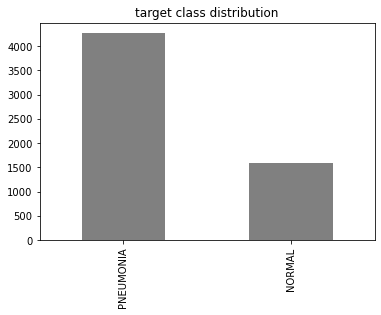

In [9]:
dfx['labels'].value_counts().plot(kind='bar',color='grey')
plt.title('target class distribution')

In [10]:
x_data=dfx['filename']
y_data=dfx['labels']
y_data=np.array(y_data)
class_weights=None
if c_w==True:
  class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_data),
                                                 y_data)
  print('The class weights are')
  print(class_weights)  

le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)
y_data = le.fit_transform(y_data)
y_data = ohe.fit_transform(y_data.reshape(-1,1))
#print(y_data.shape)
#print(y_data)

inv_y_data = ohe.inverse_transform(y_data)
inv_y_data = le.inverse_transform(inv_y_data.astype(int).ravel())
#print(inv_y_data)



#y_data=pd.get_dummies(y_data)
x_train,x_val,y_train,y_val=train_test_split(x_data,y_data,test_size=split,random_state=random_state,stratify=dfx.labels.values)

y_train,y_val=np.array(y_train),np.array(y_val)

print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

The class weights are
[1.84965256 0.68523286]
(3513,) (3513, 2) (2343,) (2343, 2)


C:\Users\User\.conda\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['NORMAL' 'PNEUMONIA'], y=['NORMAL' 'NORMAL' 'NORMAL' ... 'NORMAL' 'NORMAL' 'NORMAL'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [11]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

((3513,), (3513, 2), (2343,), (2343, 2))

# Self_Supervision

In [12]:
if self_supervision==True:
    class Generate_data_self(Dataset):
        def __init__(self,length,data_type,transform=None):

            self.transform = transform
            self.length=length
            self.data_type=data_type

        def __len__(self):
            return self.length


        def __getitem__(self, idx):
            if self.data_type=='train':
                image=Image.open(x_train.iloc[idx]).convert('RGB')    
            if self.transform:
                image=self.transform(image)
            #print(image.shape)
            label=image
            label=torch.flatten(label)
            return [image,label]
        
  

    trans_train = transforms.Compose([
                                    
        transforms.Resize((W,H)),

        
        #Play with some augmentations check what what works better
        
        # torchvision.transforms.RandomChoice([
        # #torchvision.transforms.ColorJitter(brightness=10, contrast=10),
        # transforms.RandomRotation(20),
        # torchvision.transforms.RandomHorizontalFlip(),
        # #torchvision.transforms.RandomCrop(2),
        # torchvision.transforms.RandomVerticalFlip(),
        # #torchvision.transforms.RandomAffine((-5,5)),
        # ]), 
    # ImageNetPolicy(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet normalization policy check if it works better or not
    ])


    train_set = Generate_data_self(length=x_train.shape[0],data_type='train', transform = trans_train)

    image_datasets = {
        'train': train_set
    }



    dataloader = {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    }

    mse=torch.nn.MSELoss()
    if model_name=='resnet18':
        model=models.resnet18(pretrained=pretrained)
        num_ftrs=model.fc.in_features
        model.fc=nn.Linear(num_ftrs,W*H*N_channel)
        model=model.to(device)
    def print_metrics(metrics, epoch_samples, phase):
        outputs = []
        for k in metrics.keys():
            outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

        print("{}: {}".format(phase, ", ".join(outputs)))

    def train_model(optimizer, scheduler, num_epochs=25):
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = 1e10
        #best_acc=-1
        #best_f1 = -1

        for epoch in tqdm.tnrange(num_epochs):
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
            print('~' * 10)

            since = time.time()

            # Each epoch has a training and validation phase
            for phase in ['train']:
                if phase == 'train':
                    
                    for param_group in optimizer.param_groups:
                        print("LR", param_group['lr'])

                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                metrics = defaultdict(float)
                epoch_samples = 0

                for inputs, labels in dataloader[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = torch.sqrt(mse(outputs,labels))
                        metrics['loss'] += loss.data.cpu().numpy() * labels.size(0)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            

                    # statistics
                    epoch_samples += inputs.size(0) #number of total samples in one epoch

                #after each epoch ends the following lines prints and measures the metrics
                print_metrics(metrics, epoch_samples, phase)
                epoch_loss = metrics['loss'] / epoch_samples
               
                # deep copy the model
                if phase == 'train':
                    if epoch_loss<best_loss:
                        best_model_wts = copy.deepcopy(model.state_dict())
                        best_loss=epoch_loss
                    scheduler.step()           
                     

            time_elapsed = time.time() - since
            print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
           


        print('Best loss: {:4f}'.format(best_loss))
        model.load_state_dict(best_model_wts)
        return model


    optimizer_ft = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=0.1)

    model = train_model(optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH)      

C:\Users\User\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:77: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Epoch 1/30
~~~~~~~~~~
LR 0.001
train: loss: 0.144269
0m 59s
Epoch 2/30
~~~~~~~~~~
LR 0.001
train: loss: 0.121047
0m 56s
Epoch 3/30
~~~~~~~~~~
LR 0.001
train: loss: 0.111489
0m 54s
Epoch 4/30
~~~~~~~~~~
LR 0.001
train: loss: 0.104445
0m 53s
Epoch 5/30
~~~~~~~~~~
LR 0.001
train: loss: 0.097615
0m 53s
Epoch 6/30
~~~~~~~~~~
LR 0.001
train: loss: 0.092752
0m 53s
Epoch 7/30
~~~~~~~~~~
LR 0.001
train: loss: 0.088313
0m 53s
Epoch 8/30
~~~~~~~~~~
LR 0.001
train: loss: 0.085809
0m 53s
Epoch 9/30
~~~~~~~~~~
LR 0.001
train: loss: 0.082852
0m 53s
Epoch 10/30
~~~~~~~~~~
LR 0.001
train: loss: 0.081002
0m 53s
Epoch 11/30
~~~~~~~~~~
LR 0.001
train: loss: 0.077966
0m 55s
Epoch 12/30
~~~~~~~~~~
LR 0.001
train: loss: 0.076181
0m 54s
Epoch 13/30
~~~~~~~~~~
LR 0.001
train: loss: 0.073929
0m 53s
Epoch 14/30
~~~~~~~~~~
LR 0.001
train: loss: 0.072633
0m 53s
Epoch 15/30
~~~~~~~~~~
LR 0.001
train: loss: 0.070638
0m 53s
Epoch 16/30
~~~~~~~~~~
LR 0.001
train: loss: 0.069778
0m 53s
Epoch 17/30
~~~~~~~~~~
LR 0.001
t

# Datagenerator

In [13]:
class Generate_data(Dataset):
    def __init__(self,length,data_type,transform=None):

        self.transform = transform
        self.length=length
        self.data_type=data_type

    def __len__(self):
        return self.length





    def __getitem__(self, idx):
        if self.data_type=='train':
          image=Image.open(x_train.iloc[idx]).convert('RGB')    
          if self.transform:
            image=self.transform(image)
          #print(image.shape)
          label=y_train[idx]
          return [image,label]
        
        if self.data_type=='val':
          image=Image.open(x_val.iloc[idx]).convert('RGB')    
          if self.transform:
            image=self.transform(image)
          label=y_val[idx]
          return [image,label]
        
        # if self.data_type=='test':
        #   image=Image.open('../odir_dataset/preprocessed_images/'+test_df.iloc[idx]['Image'])    
        #   if self.transform:
        #     image=self.transform(image)      
        #   return image


trans_train = transforms.Compose([
                                  
    transforms.Resize((W,H)),

    
    #Play with some augmentations check what what works better
    
    torchvision.transforms.RandomChoice([
    #torchvision.transforms.ColorJitter(brightness=10, contrast=10),
    transforms.RandomRotation(20),
    torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.RandomCrop(2),
    torchvision.transforms.RandomVerticalFlip(),
    #torchvision.transforms.RandomAffine((-5,5)),
    ]), 
   # ImageNetPolicy(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet normalization policy check if it works better or not
])


trans_val = transforms.Compose([
    transforms.Resize((W,H)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

if self_supervision==True:
  trans_train = transforms.Compose([
                                  
    transforms.Resize((W,H)),

    
    #Play with some augmentations check what what works better
    
    torchvision.transforms.RandomChoice([
    #torchvision.transforms.ColorJitter(brightness=10, contrast=10),
    transforms.RandomRotation(20),
    torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.RandomCrop(2),
    torchvision.transforms.RandomVerticalFlip(),
    #torchvision.transforms.RandomAffine((-5,5)),
    ]), 
   # ImageNetPolicy(),
    transforms.ToTensor(),
   # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet normalization policy check if it works better or not
])


trans_val = transforms.Compose([
    transforms.Resize((W,H)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_set = Generate_data(length=x_train.shape[0],data_type='train', transform = trans_train)
val_set = Generate_data(length=x_val.shape[0],data_type='val', transform = trans_val)
#test_set = Generate_data(length=test_df.shape[0],data_type='test',transform=trans_val)
image_datasets = {
    'train': train_set, 'val': val_set#, 'test':test_set
}



dataloader = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    #'test': DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0),
}

torch.Size([8, 3, 224, 224]) torch.Size([8, 2])


Text(0.5, 1.0, 'NORMAL')

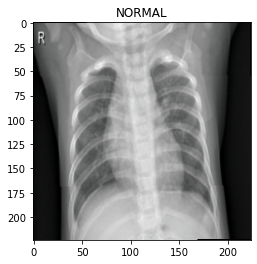

In [14]:
inputs,label=next(iter(dataloader['train']))
print(inputs.shape,label.shape)
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    #print(inp.shape)
    if pretrained == True:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      if self_supervision==False:
        inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    
    inp = (inp * 255).astype(np.uint8)
    #inp=np.reshape(inp,(inp.shape[0],inp.shape[1]))

    return inp

#print(inputs.shape)
plt.imshow(reverse_transform(inputs[0]))

label_data = ohe.inverse_transform(label) 
label_data = le.inverse_transform(label_data.astype(int).ravel())
plt.title(label_data[0])

# Attention Based EffecientNet

In [15]:
class PositionAttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(PositionAttentionModule, self).__init__()
        self.first_branch_conv = nn.Conv2d(in_channels, int(in_channels/8), kernel_size = 1)
        self.second_branch_conv = nn.Conv2d(in_channels, int(in_channels/8), kernel_size = 1)
        self.third_branch_conv = nn.Conv2d(in_channels, in_channels, kernel_size = 1)
        self.output_conv = nn.Conv2d(in_channels, in_channels, kernel_size = 1)
    
    def forward(self, F):
        # first branch
        F1 = self.first_branch_conv(F)                  # (C/8, W, H)
        F1 = F1.reshape((F1.size(0), F1.size(1), -1))   # (C/8, W*H)
        F1 = torch.transpose(F1, -2, -1)                # (W*H, C/8)
        # second branch
        F2 = self.second_branch_conv(F)                 # (C/8, W, H)
        F2 = F2.reshape((F2.size(0), F2.size(1), -1))   # (C/8, W*H)
        F2 = nn.Softmax(dim = -1)(torch.matmul(F1, F2)) # (W*H, W*H)
        # third branch
        F3 = self.third_branch_conv(F)                  # (C, W, H)
        F3 = F3.reshape((F3.size(0), F3.size(1), -1))   # (C, W*H)
        F3 = torch.matmul(F3, F2)                       # (C, W*H)
        F3 = F3.reshape(F.shape)                        # (C, W, H)
        return self.output_conv(F3*F)
 
class ChannelAttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(ChannelAttentionModule, self).__init__()
        self.output_conv = nn.Conv2d(in_channels, in_channels, kernel_size = 1)
    
    def forward(self, F):
        # first branch
        F1 = F.reshape((F.size(0), F.size(1), -1))      # (C, W*H)
        F1 = torch.transpose(F1, -2, -1)                # (W*H, C)
        # second branch
        F2 = F.reshape((F.size(0), F.size(1), -1))      # (C, W*H)
        F2 = nn.Softmax(dim = -1)(torch.matmul(F2, F1)) # (C, C)
        # third branch
        F3 = F.reshape((F.size(0), F.size(1), -1))      # (C, W*H)
        F3 = torch.matmul(F2, F3)                       # (C, W*H)
        F3 = F3.reshape(F.shape)                        # (C, W, H)
        return self.output_conv(F3*F)
 
class GuidedAttentionModule(nn.Module):
    def __init__(self, in_channels_F, in_channels_Fms):
        super(GuidedAttentionModule, self).__init__()
        in_channels = in_channels_F + in_channels_Fms
        self.pam = PositionAttentionModule(in_channels)
        self.cam = ChannelAttentionModule(in_channels)
        self.encoder = nn.Sequential(nn.Conv2d(in_channels, 2*in_channels, kernel_size = 3),
                                     nn.BatchNorm2d(2*in_channels),
                                     nn.Conv2d(2*in_channels, 4*in_channels, kernel_size = 3),
                                     nn.BatchNorm2d(4*in_channels),
                                     nn.ReLU())
        self.decoder = nn.Sequential(nn.ConvTranspose2d(4*in_channels, 2*in_channels, kernel_size = 3),
                                     nn.BatchNorm2d(2*in_channels),
                                     nn.ConvTranspose2d(2*in_channels, in_channels, kernel_size = 3),
                                     nn.BatchNorm2d(in_channels),
                                     nn.ReLU())
        self.attention_map_conv = nn.Sequential(nn.Conv2d(in_channels, in_channels_Fms, kernel_size = 1),
                                                nn.BatchNorm2d(in_channels_Fms),
                                                nn.ReLU())
        
    def forward(self, F, F_ms):
        F = torch.cat((F, F_ms), dim = 1)         # concatenate the extracted feature map with the multi scale feature map
        F_pcam = self.pam(F) + self.cam(F)        # sum the ouputs of the position and channel attention modules
        F_latent = self.encoder(F)                # latent-space representation, used for the guided loss
        F_reconstructed = self.decoder(F_latent)  # output of the autoencoder, used for the reconstruction loss
        F_output = self.attention_map_conv(F_reconstructed * F_pcam)
        F_output = F_output * F_ms
        return F_output, F_reconstructed, F_latent

In [16]:
"""
https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_efficientnet.py
"""
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            #PositionAttentionModule(in_channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)
        #self.attention_layer=PositionAttentionModule(in_channels)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs+inputs
        else:
            return self.conv(x)


class AEfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(AEfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))


# Sine Based Res connection Resnet

In [17]:
"""
https://github.com/FrancescoSaverioZuppichini/ResNet/blob/master/ResNet.ipynb
"""
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)
conv = conv3x3(in_channels=32, out_channels=64)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()  
        self.sine_activation=Sine(1.0)
    
    def forward(self, x):
        residual = x
   
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x += self.sine_activation(residual)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )


class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )


class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x   

class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)
        

    def forward(self, x):
        #print(x.shape)
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x  

class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
"""
https://github.com/lucidrains/siren-pytorch
for siren 
"""
def sine_resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def sine_resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def sine_resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def sine_resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def sine_resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

# Experiment

In [18]:
class Experiment(nn.Module):
    def __init__(self,name):
        super().__init__()
        self.effnet=EfficientNet.from_pretrained(name)
        #print(self.effnet)
        #self.dense=self.effnet._fc
        self.num_ftrs = self.effnet._fc.out_features
        self.lstm=nn.LSTM(self.num_ftrs,128,2,batch_first=True,bidirectional=False)
        #self.dense_1=nn.Linear(self.num_ftrs, 3072)
        #self.multi_head_attention=nn.MultiheadAttention(1024,2)
        self.dense_2=nn.Linear(128,y_train.shape[1])
        #self.resnet18=models.resnet18(pretrained=pretrained)
        #self.res_num_ftrs = self.resnet18.fc.in_features
        #self.resnet18.fc = nn.Linear(self.res_num_ftrs, y_train.shape[1])
    def forward(self,x):
        #print(self.effnet(x))
       # print(self.dense(x))
        x=self.effnet(x)
        #print(x.shape)
        x=torch.reshape(x,shape=(x.shape[0],1,x.shape[1]))
        #print(x.shape)

        x,_=self.lstm(x)

       # print(x.shape)
        x=self.dense_2(x)
        #print(x.shape)
        x=torch.reshape(x,shape=(x.shape[0],y_train.shape[1]))
        #x=self.resnet18(x)
        return x

# Getting The Model

In [17]:
if model_name=='resnet50':
    model_ft = models.resnet50(pretrained=pretrained)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, y_train.shape[1])
if model_name=='resnet18':
    if self_supervision==True:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, y_train.shape[1])
    else:
        model_ft = models.resnet18(pretrained=pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, y_train.shape[1])
if model_name=='vgg16':
    model_ft = models.vgg16(pretrained=pretrained)
    num_ftrs = model_ft.classifier[6].in_features
    features = list(model_ft.classifier.children())[:-1] # Remove last layer
    features.extend([nn.Linear(num_ftrs,  y_train.shape[1])])
    model_ft.classifier = nn.Sequential(*features) #*(star ) infront of list means it unpacks the elements
if model_name=='ResNeXt50':
    model_ft = models.resnext50_32x4d(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, y_train.shape[1])  

if model_name=='effnetb0':
    model_ft=EfficientNet.from_pretrained('efficientnet-b0')
    num_ftrs = model_ft._fc.in_features
    model_ft._fc = nn.Linear(num_ftrs, y_train.shape[1])

if model_name=='effnetb5':
    model_ft=EfficientNet.from_pretrained('efficientnet-b5')
    num_ftrs = model_ft._fc.in_features
    model_ft._fc = nn.Linear(num_ftrs, y_train.shape[1])

if model_name=='effnetb6':
    model_ft=EfficientNet.from_pretrained('efficientnet-b6')
    num_ftrs = model_ft._fc.in_features
    model_ft._fc = nn.Linear(num_ftrs, y_train.shape[1])

if model_name=='effnetb3':
    model_ft=EfficientNet.from_pretrained('efficientnet-b3')
    num_ftrs = model_ft._fc.in_features
    model_ft._fc = nn.Linear(num_ftrs, y_train.shape[1])

if model_name=='effnetb7':
    model_ft=EfficientNet.from_pretrained('efficientnet-b7')
    num_ftrs = model_ft._fc.in_features
    model_ft._fc = nn.Linear(num_ftrs, y_train.shape[1])

if model_name=='effnetb4':
    model_ft=EfficientNet.from_pretrained('efficientnet-b4')
    num_ftrs = model_ft._fc.in_features
    model_ft._fc = nn.Linear(num_ftrs, y_train.shape[1])
if model_name=='effnetb1':
    model_ft=EfficientNet.from_pretrained('efficientnet-b1')
    num_ftrs = model_ft._fc.in_features
    model_ft._fc = nn.Linear(num_ftrs, y_train.shape[1])
if model_name=='effnetb2':
    model_ft=EfficientNet.from_pretrained('efficientnet-b2')
    num_ftrs = model_ft._fc.in_features
    model_ft._fc = nn.Linear(num_ftrs, y_train.shape[1])
if model_name=='effnet_b1_lstm':
    model_ft=Experiment('efficientnet-b1')


if model_name=='sine_resnet18':
    model_ft = sine_resnet18(3,y_train.shape[1])
if model_name=='attn_effnetb1':
    model_ft=AEfficientNet(
        version="b1",
        num_classes=y_train.shape[1]
    )
if model_name=='experiment':
    model_ft=Experiment('efficientnet-b1')
    #num_ftrs = model_ft.fc.in_features
    #model_ft.fc = nn.Linear(num_ftrs, y_train.shape[1]) 
#print(num_ftrs)

if self_supervision==False:
    model=model_ft
    
    del model_ft
model=model.to(device)
#print(summary(model, input_size=(3, W, H)))
# return model

In [20]:
# torch.cuda.empty_cache()
#model=get_model(model_name)

In [21]:
# model = pretrainedmodels.__dict__[model_name](num_classes=8,pretrained=)

In [22]:
#print(summary(model,(3,W,H)))

# Performance Metrics

In [18]:
def calc_loss(preds,labels,metrics,class_weights=None):
    #class_weights=torch.from_numpy(class_weights)
    if c_w==True:
      if use_cuda:
        class_weights=torch.cuda.FloatTensor(class_weights)
      ce_loss=torch.nn.CrossEntropyLoss(weight=class_weights)
    else:
      ce_loss=torch.nn.CrossEntropyLoss()
    labels=torch.from_numpy(np.argmax(labels.data.cpu().numpy(),axis=1)).cuda()
    
    loss=ce_loss(preds,labels)
    metrics['loss'] += loss.data.cpu().numpy() * labels.size(0)
    return loss

def calc_acc(preds,labels,metrics):
    _, preds = torch.max(preds, 1)#pred contains the max valued index
    labels=torch.from_numpy(np.argmax(labels.data.cpu().numpy(),axis=1)).cuda()
    #print(preds.shape,labels.shape)
    metrics['Acc.'] += torch.sum(preds == labels.data)

def calc_other_metric(preds,labels,metrics):
    """
    Calculates Precision, Recall & F1 score
    """
    _, preds = torch.max(preds, 1)#pred contains the max valued index
    preds=preds.data.cpu().numpy()
    labels=np.argmax(labels.data.cpu().numpy(),axis=1)

    f1=f1_score(labels,preds,average = 'macro')* labels.shape[0]
    metrics['F1_Score'] +=f1

    p_score=precision_score(labels,preds,average='macro')* labels.shape[0]
    metrics['Precision'] +=p_score

    r_score=recall_score(labels,preds,average='macro')* labels.shape[0]
    metrics['Recall'] +=r_score


    
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))




# Train Functionality

In [20]:
train_acc_list=[]
val_acc_list=[]

train_f1_list=[]
val_f1_list=[]

train_precision_list=[]
val_precision_list=[]

train_recall_list=[]
val_recall_list=[]

train_loss_list=[]
val_loss_list=[]

def train_model(optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    #best_acc=-1
    #best_f1 = -1

    for epoch in tqdm.tnrange(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('~' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics,class_weights)
                    calc_acc(outputs, labels,metrics)#no return just calc Acc.
                    calc_other_metric(outputs,labels,metrics)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # statistics
                epoch_samples += inputs.size(0) #number of total samples in one epoch

            #after each epoch ends the following lines prints and measures the metrics
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_acc = metrics['Acc.'] / epoch_samples
            epoch_f1 = metrics['F1_Score'] / epoch_samples
            epoch_prec= metrics['Precision'] / epoch_samples
            epoch_recall= metrics['Recall'] / epoch_samples
            # deep copy the model
            if phase == 'val':
                if epoch_loss<best_loss:
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_loss=epoch_loss
                    torch.save(model.state_dict(), saved_model_name)

                val_acc_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)
                val_recall_list.append(epoch_recall)
                val_precision_list.append(epoch_prec)
                val_f1_list.append(epoch_f1)
            if phase=='train':
                train_acc_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
                train_recall_list.append(epoch_recall)
                train_precision_list.append(epoch_prec)
                train_f1_list.append(epoch_f1) 
                scheduler.step()           
            #   if epoch_acc>best_acc:
            #     best_acc=epoch_acc
            #   if epoch_f1>best_f1:
            #     best_f1=epoch_f1 
            #   if epoch_prec>best              
                

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        #print('val loss: ',epoch_loss,' val acc: ',epoch_acc,' val f1 ',epoch_f1)


    print('Best val loss: {:4f}'.format(min(val_loss_list)))
    print('Best val acc: {:4f}'.format(max(val_acc_list)))
    print('Best val f1: {:4f}'.format(max(val_f1_list)))
    print('Best val prec: {:4f}'.format(max(val_precision_list)))
    print('Best val recall: {:4f}'.format(max(val_recall_list)))
     # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Training and validation Specific model

In [21]:
if only_eval==False:
    """
    Model is trained with adam optimizer and saved everytime if current epoch loss is less than the untill observed best validation loss
    """

    optimizer_ft = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=0.1)

    model = train_model(optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH)

C:\Users\User\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


C:\Users\User\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
~~~~~~~~~~
LR 0.001


C:\Users\User\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train: loss: 0.277141, Acc.: 0.875890, F1_Score: 0.825710, Precision: 0.833053, Recall: 0.863468
val: loss: 0.149216, Acc.: 0.953905, F1_Score: 0.931570, Precision: 0.939252, Recall: 0.940685
1m 35s
Epoch 2/30
~~~~~~~~~~
LR 0.001
train: loss: 0.188114, Acc.: 0.929690, F1_Score: 0.894643, Precision: 0.900107, Recall: 0.916117
val: loss: 0.187677, Acc.: 0.952625, F1_Score: 0.928894, Precision: 0.938737, Recall: 0.933870
1m 34s
Epoch 3/30
~~~~~~~~~~
LR 0.001
train: loss: 0.171491, Acc.: 0.941645, F1_Score: 0.906076, Precision: 0.911258, Recall: 0.924611
val: loss: 0.352548, Acc.: 0.819035, F1_Score: 0.768830, Precision: 0.790564, Recall: 0.829258
1m 34s
Epoch 4/30
~~~~~~~~~~
LR 0.001
train: loss: 0.150439, Acc.: 0.947623, F1_Score: 0.917365, Precision: 0.921985, Recall: 0.931506
val: loss: 0.176366, Acc.: 0.958600, F1_Score: 0.934517, Precision: 0.950206, Recall: 0.935006
1m 28s
Epoch 5/30
~~~~~~~~~~
LR 0.001
train: loss: 0.135821, Acc.: 0.952747, F1_Score: 0.926047, Precision: 0.930931, 

# Validation set result

In [22]:
model.load_state_dict(torch.load(saved_model_name))
# model.eval()

<All keys matched successfully>

In [23]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)
#pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

11177538


In [24]:
def get_val_results():
  y_val_pred=np.empty(0)
  model.eval()
  for inputs,labels in dataloader['val']:
    inputs = inputs.to(device)
    outputs = model(inputs)
    #_, outputs = torch.max(outputs, 1)#pred contains the max valued index

    softmax=torch.nn.Softmax()
    outputs=softmax(outputs)
    outputs=outputs.data.cpu().numpy()
    outputs=np.argmax(outputs,axis=1)
    outputs = le.inverse_transform(outputs.astype(int).ravel())
    y_val_pred=np.append(y_val_pred,outputs)

  return y_val_pred



In [25]:
y_val_pred=get_val_results()

C:\Users\User\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [30]:
# sub1=pd.read_csv('D:\combined research with rumi\codes\weatherrfs\infos\\0e27a6d0-a926-11eb-a70b-18c04d25d0fd_ResNeXt50_sub.csv')
# gt1=sub1['gt']
# pr1=sub1['predicted']
# accuracy_score(gt1,pr1)

In [26]:
y_val_gt=np.argmax(y_val,axis=1)
y_val_gt=le.inverse_transform(y_val_gt.astype(int).ravel())

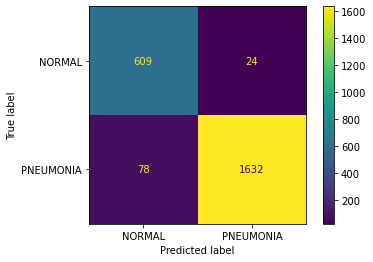

In [27]:
conf_matrix=confusion_matrix(y_val_gt,y_val_pred)
conf_disp=ConfusionMatrixDisplay(conf_matrix,display_labels=set(y_val_gt))
conf_disp.plot()
plt.savefig(SUB_PATH+str(cur_time_stamp)+model_name+'_'+"conf_mat.png")

In [28]:
if only_eval==False:
    with open(log_file,'w') as f:
        print('Best val loss: {:4f}'.format(min(val_loss_list)),file=f)
        print('Best val acc: {:4f}'.format(max(val_acc_list)),file=f)
        print('Best val f1: {:4f}'.format(max(val_f1_list)),file=f)
        print('Best val prec: {:4f}'.format(max(val_precision_list)),file=f)
        print('Best val recall: {:4f}'.format(max(val_recall_list)),file=f)
if only_eval==True:
    with open(log_file,'w') as f:
        print('val acc: {:4f}'.format(accuracy_score(y_val_gt,y_val_pred)),file=f)
        print('val f1: {:4f}'.format(f1_score(y_val_gt,y_val_pred,average = 'macro')),file=f)
        print('val prec: {:4f}'.format(precision_score(y_val_gt,y_val_pred,average = 'macro')),file=f)
        print('val recall: {:4f}'.format(recall_score(y_val_gt,y_val_pred,average = 'macro')),file=f)



In [29]:
if only_eval==False:   
    epoch_result = pd.DataFrame( columns = ['loss_train','loss_val','acc_train','acc_val','f1_train','f1_val','precision_train','precision_val','recall_train','recall_val'])
    epoch_result['loss_train']=train_loss_list
    epoch_result['loss_val']=val_loss_list
    epoch_result['acc_train']=train_acc_list
    epoch_result['acc_val']=val_acc_list
    epoch_result['f1_train']=train_f1_list
    epoch_result['f1_val']=val_f1_list
    epoch_result['precision_train']=train_precision_list
    epoch_result['precision_val']=val_precision_list
    epoch_result['recall_train']=train_recall_list
    epoch_result['recall_val']=val_recall_list
    print(epoch_result.head())
    epoch_result.to_csv(epoch_csv)

submission = pd.DataFrame( columns = ['filename','predicted','gt'])
submission['filename']=x_val
submission["predicted"]=y_val_pred
submission['gt']=y_val_gt
print(submission.head())
submission.to_csv(saved_submission_file, index=False)

   loss_train  loss_val  acc_train   acc_val  f1_train    f1_val  precision_train  precision_val  recall_train  recall_val
0    0.277141  0.149216   0.875890  0.953905  0.825710  0.931570         0.833053       0.939252      0.863468    0.940685
1    0.188114  0.187677   0.929690  0.952625  0.894643  0.928894         0.900107       0.938737      0.916117    0.933870
2    0.171491  0.352548   0.941645  0.819035  0.906076  0.768830         0.911258       0.790564      0.924611    0.829258
3    0.150439  0.176366   0.947623  0.958600  0.917365  0.934517         0.921985       0.950206      0.931506    0.935006
4    0.135821  0.251000   0.952747  0.890738  0.926047  0.852440         0.930931       0.858468      0.941533    0.893161
                                               filename  predicted         gt
979   chest_xray/train/NORMAL/NORMAL2-IM-0931-0001.jpeg     NORMAL     NORMAL
3116  chest_xray/train/PNEUMONIA/person271_virus_556...  PNEUMONIA  PNEUMONIA
5135  chest_xray/train/PNEUM

C:\Users\User\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


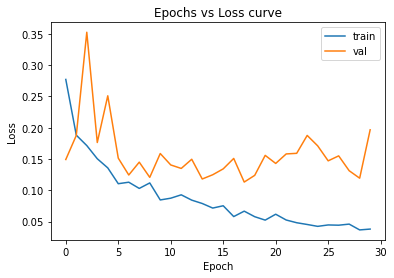

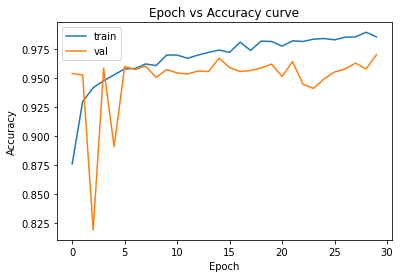

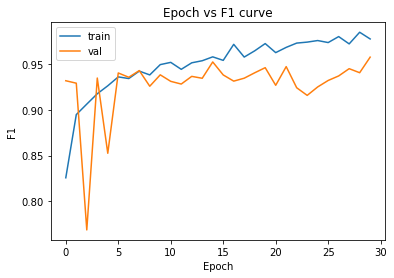

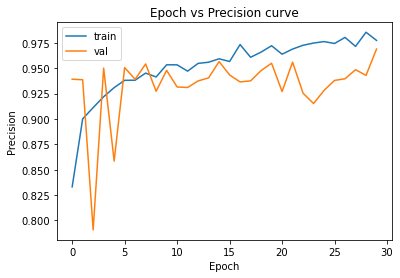

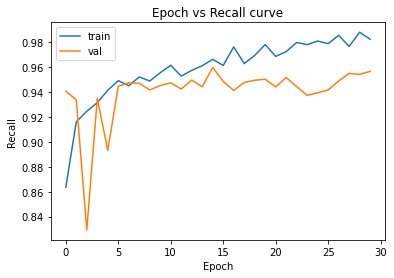

In [30]:
if only_eval==False: 
    matplotlib.use("Agg")
    epoch_result=pd.read_csv(epoch_csv)
    train_loss_list=epoch_result['loss_train']
    val_loss_list=epoch_result['loss_val']

    train_acc_list=epoch_result['acc_train']
    val_acc_list=epoch_result['acc_val']

    train_f1_list=epoch_result['f1_train']
    val_f1_list=epoch_result['f1_val']

    train_precision_list=epoch_result['precision_train']
    val_precision_list=epoch_result['precision_val']

    train_recall_list=epoch_result['recall_train']
    val_recall_list=epoch_result['recall_val']

    plt.plot(train_loss_list,label='train')
    plt.plot(val_loss_list,label='val')
    plt.title('Epochs vs Loss curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()
    plt.savefig(SUB_PATH+cur_time_stamp+'_'+model_name+'_'+'epoch_vs_loss'+'.png')

    plt.figure()
    plt.plot(train_acc_list,label='train')
    plt.plot(val_acc_list,label='val')
    plt.title('Epoch vs Accuracy curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc="best")
    plt.show()
    plt.savefig(SUB_PATH+cur_time_stamp+'_'+model_name+'_'+'epoch_vs_accuracy'+'.png')

    plt.figure()
    plt.plot(train_f1_list,label='train')
    plt.plot(val_f1_list,label='val')
    plt.title('Epoch vs F1 curve')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend(loc="best")
    plt.show()
    plt.savefig(SUB_PATH+cur_time_stamp+'_'+model_name+'_'+'epoch_vs_f1'+'.png')

    plt.figure()
    plt.plot(train_precision_list,label='train')
    plt.plot(val_precision_list,label='val')
    plt.title('Epoch vs Precision curve')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(loc="best")
    plt.show()
    plt.savefig(SUB_PATH+cur_time_stamp+'_'+model_name+'_'+'epoch_vs_precision'+'.png')

    plt.figure()
    plt.plot(train_recall_list,label='train')
    plt.plot(val_recall_list,label='val')
    plt.title('Epoch vs Recall curve')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(loc="best")
    plt.show()
    plt.savefig(SUB_PATH+cur_time_stamp+'_'+model_name+'_'+'epoch_vs_recall'+'.png')

# Ensemble

In [ ]:
# import pandas as pd
# import os
# import numpy  as np
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,precision_recall_curve
# le = LabelEncoder()
# ohe = OneHotEncoder(sparse=False)

# csvs=os.listdir('../codes/weatherrfs/selected_csv/')

# if len(csvs)>1:   
#     y_test=np.zeros(shape=(2200,5))


#     for sub in csvs:
#       cur_sub=pd.read_csv('../codes/weatherrfs/selected_csv/'+sub)
#       cur_sub=cur_sub['predicted']
#       cur_sub=le.fit_transform(cur_sub)
#       cur_sub=ohe.fit_transform(cur_sub.reshape(-1,1))
#       # print(cur_sub.shape)
#       # print(cur_sub)
#       # break
#       for i,x in enumerate(cur_sub):
#         y_test[i]=y_test[i]+x
#         # print(y_test[i])
#       #   break
#       # break

#     #print(freq)
#     y_test=np.argmax(y_test,axis=1)
#     y_test = le.inverse_transform(y_test.astype(int).ravel())


In [ ]:
# y_test_gt=pd.read_csv('D:\combined research with rumi\codes\weatherrfs\infos\\fbc48d6e-af73-11eb-b021-18c04d25d0fd_effnet_b1_lstm_sub.csv')['gt']